<a href="https://colab.research.google.com/github/ee-689-boun/tsdl/blob/main/ar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall statsmodels -y
!pip install statsmodels pmdarima yfinance

Uninstalling statsmodels-0.12.2:
  Successfully uninstalled statsmodels-0.12.2
  Using cached https://files.pythonhosted.org/packages/0d/7b/c17815648dc31396af865b9c6627cc3f95705954e30f61106795361c39ee/statsmodels-0.12.2-cp36-cp36m-manylinux1_x86_64.whl


In [66]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pmdarima as pm

# Data Prep

In [3]:
yahoo_data = yf.download("EURUSD=X", start="2017-01-01", end="2020-03-01")
yahoo_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,1.053075,1.054074,1.046572,1.052698,1.052698,0
2017-01-03,1.045916,1.049208,1.034768,1.046003,1.046003,0
2017-01-04,1.041840,1.047889,1.039134,1.041992,1.041992,0
2017-01-05,1.049869,1.060895,1.048658,1.050089,1.050089,0
2017-01-06,1.060558,1.060895,1.053963,1.060592,1.060592,0


In [4]:
yahoo_data = yahoo_data.rename(columns={"Adj Close": "EURUSD"})
yahoo_data = yahoo_data[["EURUSD"]]
yahoo_data.head()

,EURUSD
Date,
2017-01-02,1.052698
2017-01-03,1.046003
2017-01-04,1.041992
2017-01-05,1.050089
2017-01-06,1.060592


In [5]:
def find_missing_dates(df):
  all_dates = pd.date_range(start=yahoo_data.index.min(), 
                            end=yahoo_data.index.max())
  return [date for date in all_dates.difference(yahoo_data.index) 
          if not date.dayofweek in [5, 6]]

In [6]:
find_missing_dates(yahoo_data)

[Timestamp('2017-07-11 00:00:00'),
 Timestamp('2017-11-16 00:00:00'),
 Timestamp('2019-05-22 00:00:00'),
 Timestamp('2019-09-11 00:00:00'),
 Timestamp('2019-09-12 00:00:00'),
 Timestamp('2019-09-13 00:00:00'),
 Timestamp('2019-09-16 00:00:00'),
 Timestamp('2019-09-17 00:00:00'),
 Timestamp('2019-09-18 00:00:00'),
 Timestamp('2019-09-19 00:00:00'),
 Timestamp('2019-09-20 00:00:00'),
 Timestamp('2019-09-23 00:00:00'),
 Timestamp('2019-09-24 00:00:00'),
 Timestamp('2019-09-25 00:00:00'),
 Timestamp('2019-09-26 00:00:00'),
 Timestamp('2019-09-27 00:00:00'),
 Timestamp('2019-09-30 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-10-02 00:00:00'),
 Timestamp('2019-10-03 00:00:00'),
 Timestamp('2019-10-04 00:00:00'),
 Timestamp('2019-10-07 00:00:00'),
 Timestamp('2019-10-09 00:00:00')]

In [7]:
ts = yahoo_data.resample("1D").interpolate(method='time')

In [8]:
train = ts[ts.index < "2020-01-01"]
test = ts[(ts.index >= "2020-01-01") & (ts.index <= "2020-02-01")]

# ACF - PACF

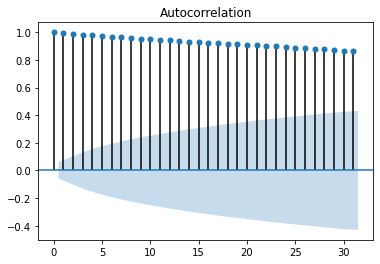

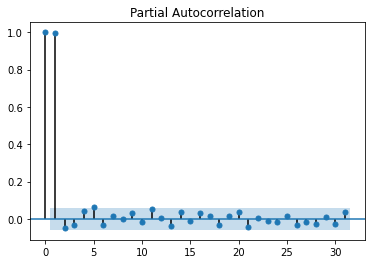

In [9]:
plot_acf(train);
plot_pacf(train);

# AR Model

In [60]:
model = AutoReg(train, lags=14)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: intercept     0.005217
EURUSD.L1     1.013952
EURUSD.L2     0.006860
EURUSD.L3    -0.027439
EURUSD.L4    -0.036004
EURUSD.L5     0.046911
EURUSD.L6    -0.050076
EURUSD.L7     0.027207
EURUSD.L8     0.004948
EURUSD.L9     0.003125
EURUSD.L10   -0.034624
EURUSD.L11    0.046182
EURUSD.L12    0.038210
EURUSD.L13   -0.081066
EURUSD.L14    0.037307
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [63]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [64]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.013


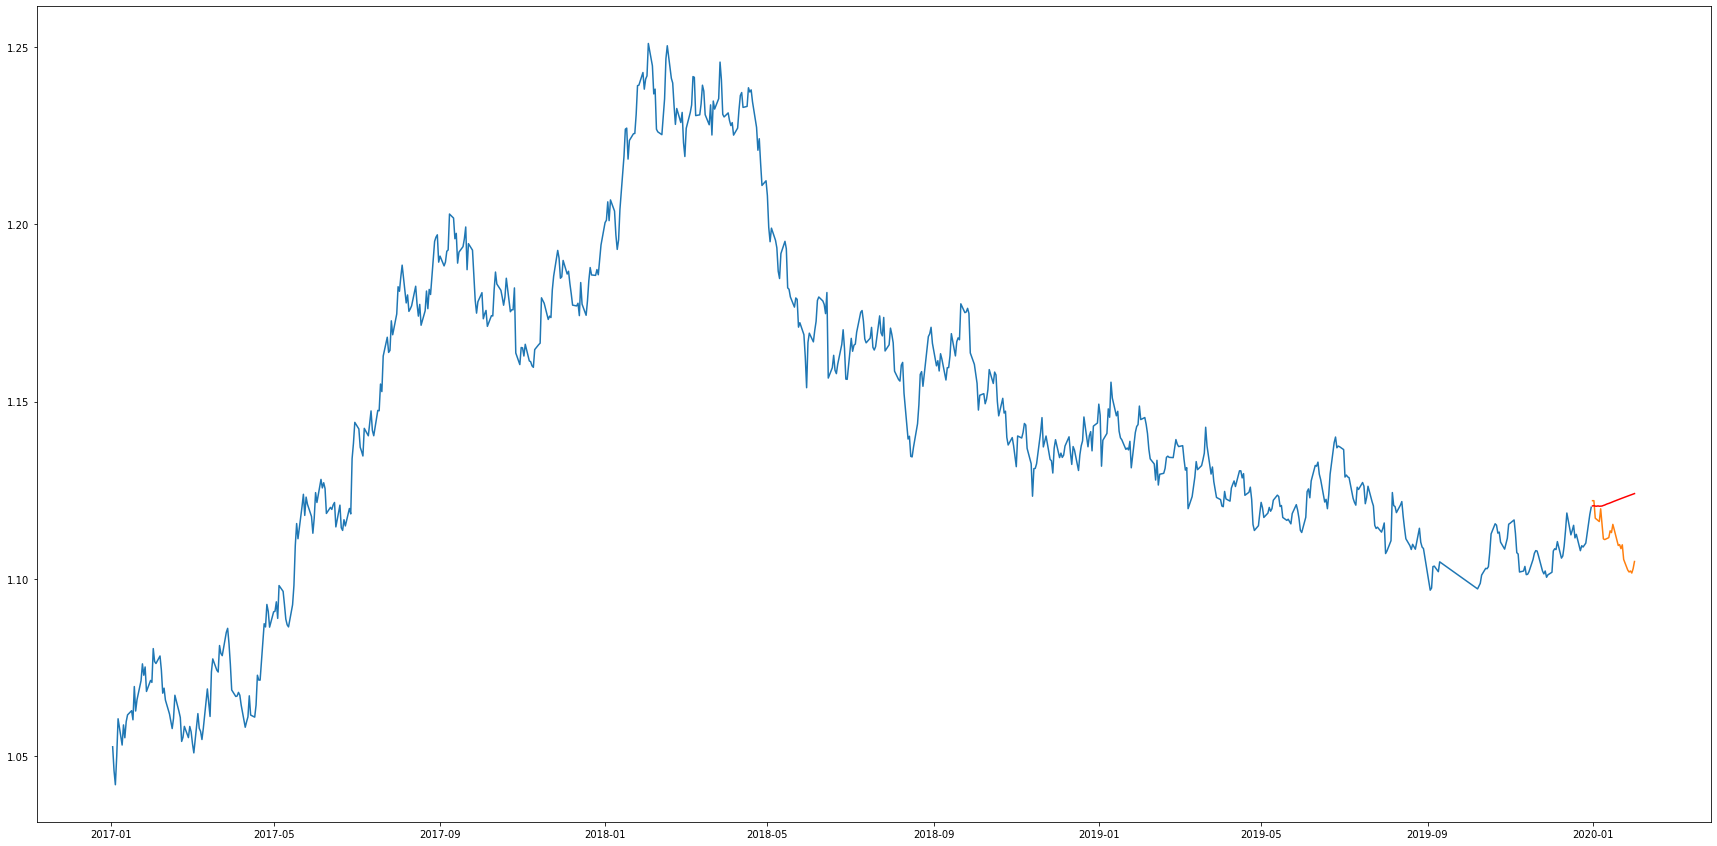

In [67]:
plt.figure(figsize=(30, 15))
# plt.plot(train.iloc[-75:])
plt.plot(train)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# AutoARIMA

In [69]:
model = pm.auto_arima(train)

In [70]:
forecasts = model.predict(test.shape[0])  # predict N steps into the future
predictions = pd.Series(forecasts, index=test.index)

In [71]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.011


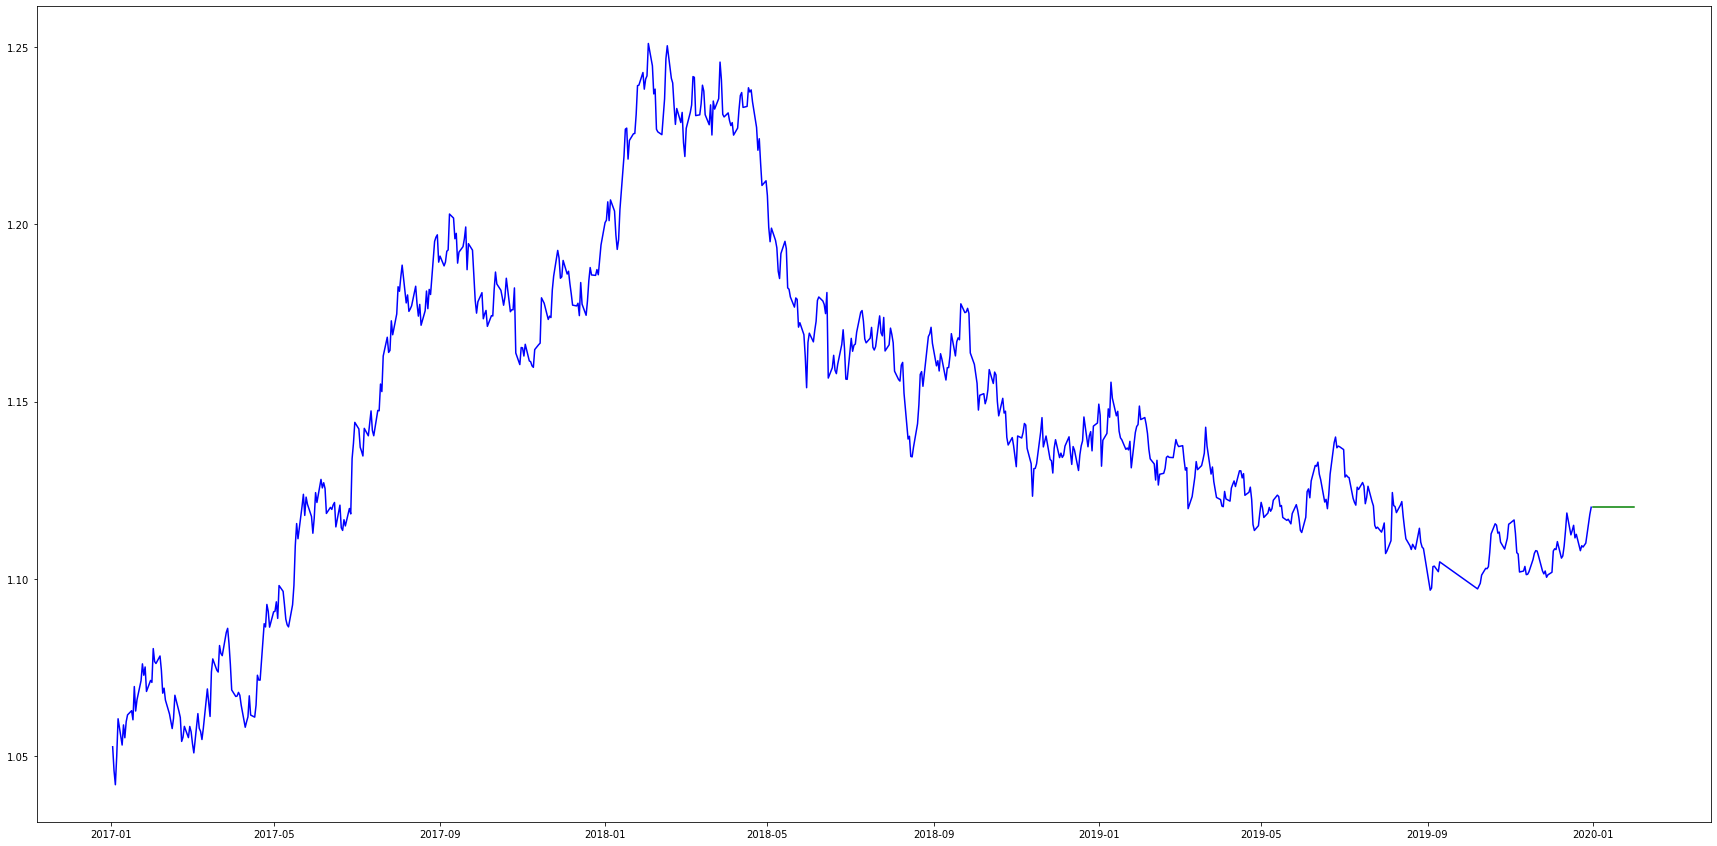

In [72]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(train.shape[0] + test.shape[0])
pyplot.figure(figsize=(30, 15))
pyplot.plot(train, c='blue')
pyplot.plot(predictions, c='green')
pyplot.show()